In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print (x_train.shape)
print (x_test.shape)
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
print (x_train.shape)
print (x_test.shape)

Using TensorFlow backend.


(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [2]:
from scipy import misc
import glob

png1 = []

for image_path in glob.glob("./data/train/*.png"):
    png1.append(misc.imread(image_path))    

x_train = np.asarray(png1)
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train,(len(x_train), 112, 112, 1))
print ('Importing done...', x_train.shape)

png2 = []

for image_path in glob.glob("./data/test/*.png"):
    png2.append(misc.imread(image_path))    

x_test = np.asarray(png2)
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test,(len(x_test), 112, 112, 1))
print ('Importing done...', x_test.shape)

Importing done... (2500, 112, 112, 1)
Importing done... (620, 112, 112, 1)


In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(112, 112, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 8)         0         
__________

In [6]:
from keras.callbacks import TensorBoard

from keras.models import load_model

autoencoder.fit(x_train, x_train,
                epochs=5, #original use 50
                batch_size=1,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='./log')])

autoencoder.save('autoencoder_v1_5e.h5')

Train on 2500 samples, validate on 620 samples
Epoch 1/5
2500/2500 [==============================] - 47s - loss: 0.6485 - val_loss: 0.6502
Epoch 2/5
2500/2500 [==============================] - 47s - loss: 0.6483 - val_loss: 0.6501
Epoch 3/5
2500/2500 [==============================] - 47s - loss: 0.6482 - val_loss: 0.6498
Epoch 4/5
2500/2500 [==============================] - 47s - loss: 0.6480 - val_loss: 0.6497
Epoch 5/5
2500/2500 [==============================] - 46s - loss: 0.6479 - val_loss: 0.6496


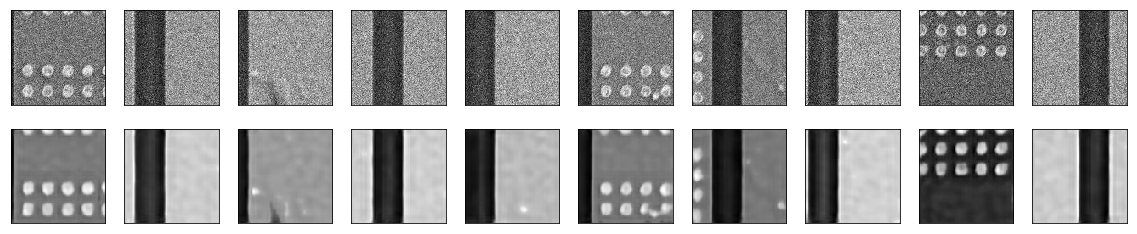

In [7]:
model = load_model('autoencoder_v1_5e.h5')

import matplotlib.pyplot as plt

decoded_imgs = model.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(112, 112))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(112, 112))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
model = load_model('autoencoder_v1_5e.h5')

decoded_imgs = model.predict(x_test)

score = model.evaluate(x_test[1].reshape(1, 112, 112, 1), decoded_imgs[1].reshape(1, 112, 112, 1), batch_size=1, verbose=1)

print ('reconstruction loss = %.4f' %(score))

1/1 [==============================] - 0s
reconstruction loss = 0.6344


Importing detection images done... (3, 112, 112, 1)
1/1 [==============================] - 0s
reconstruction loss = 0.6655
1/1 [==============================] - 0s
reconstruction loss = 0.6345
1/1 [==============================] - 0s
reconstruction loss = 0.6285
evaluation done!


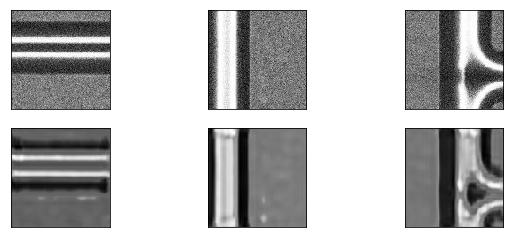

In [31]:
model = load_model('autoencoder_v1_5e.h5')

from scipy import misc
import glob

png3 = []

for image_path in glob.glob("./data/anomaly/*.png"):
    png3.append(misc.imread(image_path))    

x_detect = np.asarray(png3)
x_detect = x_detect.astype('float32') / 255.
x_detect = np.reshape(x_detect,(len(x_detect), 112, 112, 1))
print ('Importing detection images done...', x_detect.shape)

decoded_imgs = model.predict(x_detect)

for i in range(len(x_detect)):
    score = model.evaluate(x_detect[i].reshape(1, 112, 112, 1), decoded_imgs[i].reshape(1, 112, 112, 1), batch_size=1, verbose=1)
    print ('reconstruction loss = %.4f' %(score))

print('evaluation done!')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

n = len(x_detect)

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_detect[i].reshape(112, 112))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n +1)
    plt.imshow(decoded_imgs[i].reshape(112, 112))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

/home/lintong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


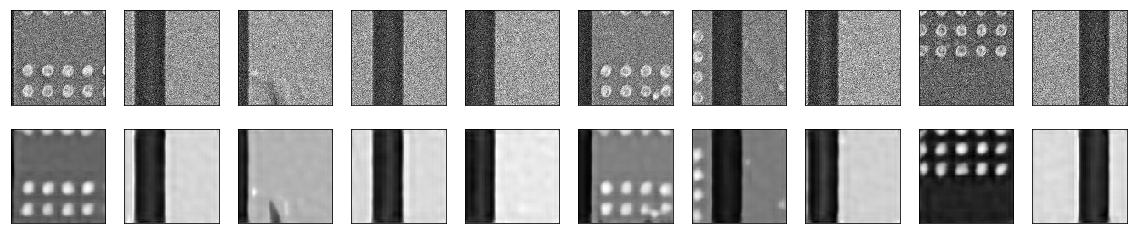

In [5]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(112, 112))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(112, 112))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()